### E24 Conditional Generative Model

- 목표 
    - 조건을 부여하여 생성 모델을 다루는 방법에 대해 이해합니다. 
    - cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하고 잘 활용합니다. 
    - CNN 기반의 모델을 구현하는데 자신감을 갖습니다.

In [108]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

#### 1. 데이터 불러오기
 - cityscapes 데이터 사용

In [109]:
data_path = os.getenv('HOME')+'/Aiffel/Exploration/24_sketch_pokemon/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


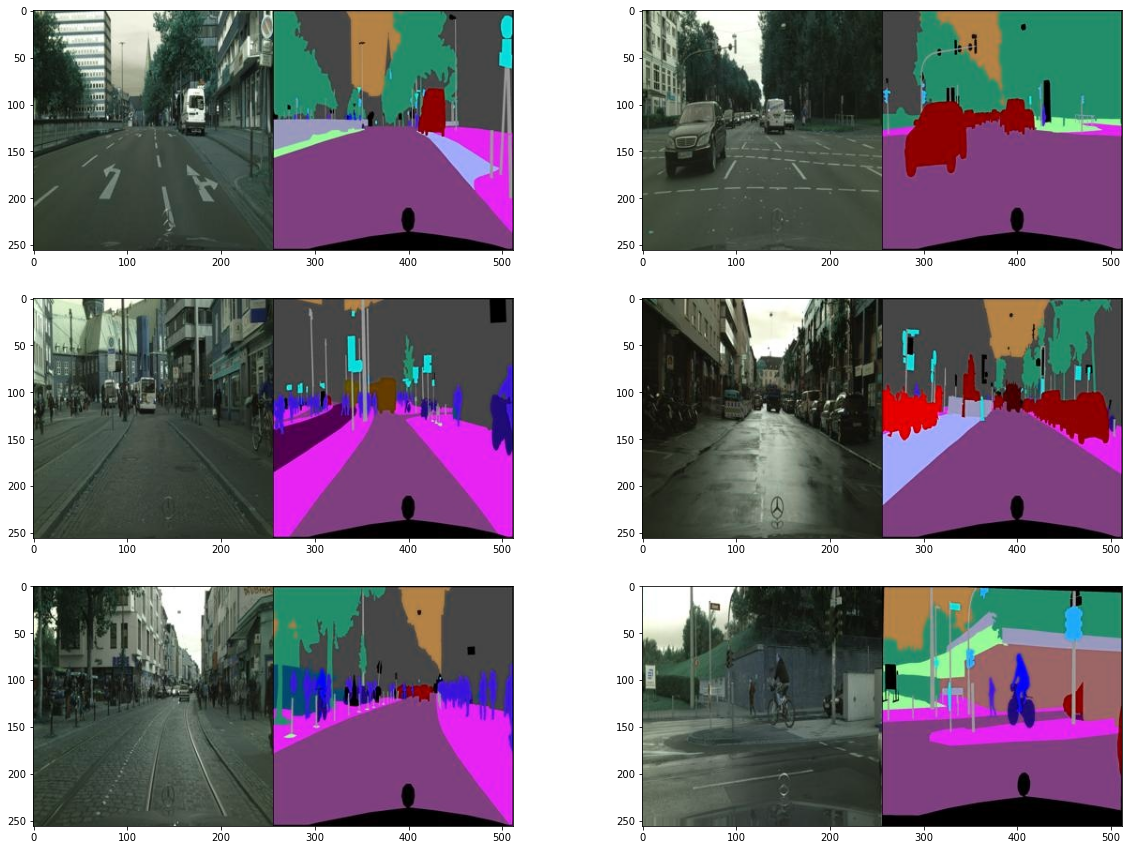

In [110]:
plt.figure(figsize=(20, 15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.imshow(img)

In [111]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


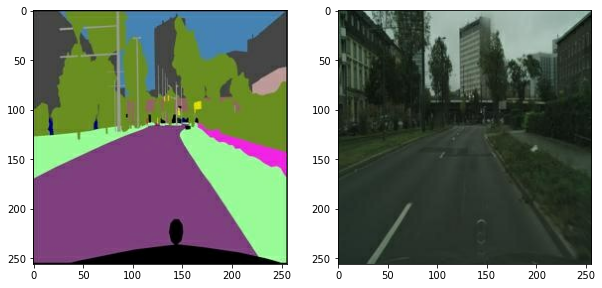

In [112]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :]
    sketch = tf.cast(sketch, tf.float32)
    ground = img[:, :w, :]
    ground = tf.cast(ground, tf.float32)
    return normalize(sketch), normalize(ground)

f = data_path + os.listdir(data_path)[1]
sketch, ground = load_img(f)

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1); plt.imshow(denormalize(sketch))
plt.subplot(1, 2, 2); plt.imshow(denormalize(ground))

#### 2. Augmentation 적용
- padding
- crop 
- 좌우 반전

In [113]:
@tf.function()
def apply_augmentation(sketch, ground):
    stacked = tf.concat([sketch, ground], axis=-1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
        
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    
        
    return out[..., :3], out[..., 3:]

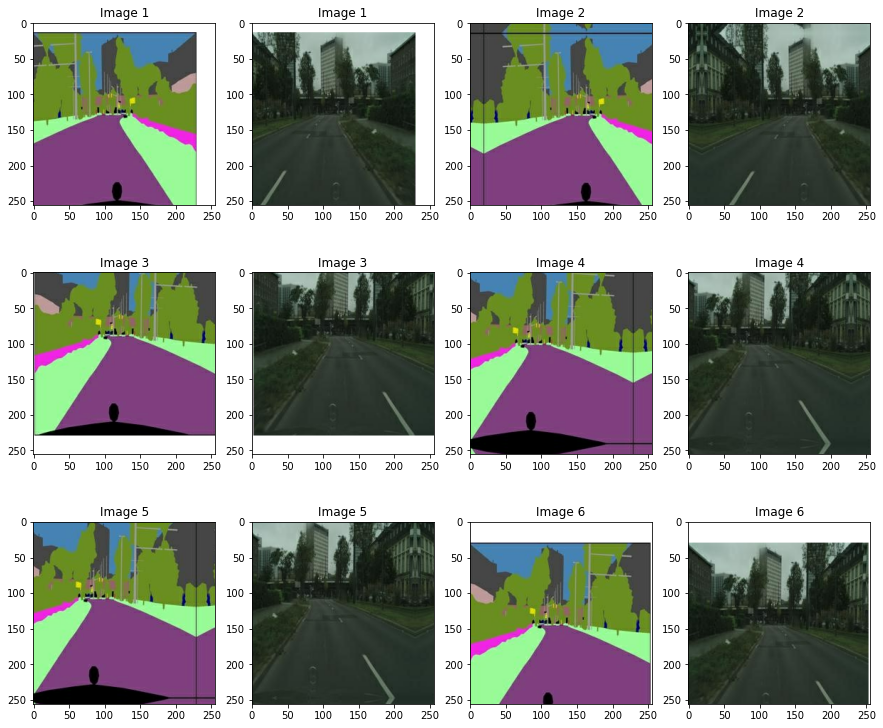

In [114]:
plt.figure(figsize=(15, 13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_ground = apply_augmentation(sketch, ground)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3, 4, i+1)
    plt.imshow(denormalize(augmented_ground)); plt.title(f"Image {img_n}")
    img_n += 1

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


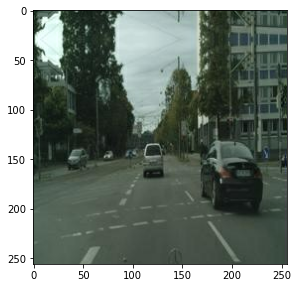

In [115]:
def get_train(img_path):
    sketch, ground = load_img(img_path)
    sketch, ground = apply_augmentation(sketch, ground)
    return sketch, ground

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0] + 1)*127.5, (sample[0][1] + 1)*127.5

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1, 2, 1); plt.imshow(colored[0].astype(np.uint8))


#### 3. 모델 구현 

In [116]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lreru = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lreru(x)

In [117]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
                
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [118]:
Encoder().get_summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_136 (EncodeBloc (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_137 (EncodeBloc (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_138 (EncodeBloc (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_139 (EncodeBloc (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_140 (EncodeBloc (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_141 (EncodeBloc (None, 4, 4, 512)       

In [119]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [120]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    def get_summary(self, input_shape=(1, 1, 256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [121]:
Decoder().get_summary()

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_119 (DecodeBloc (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_120 (DecodeBloc (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_121 (DecodeBloc (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_122 (DecodeBloc (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_123 (DecodeBloc (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_124 (DecodeBloc (None, 64, 64, 128)     

In [122]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
EncoderDecoderGenerator().get_summary()
        

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_9 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_9 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [123]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
        decode_filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
                
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
                
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
        
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
            
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
            
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [124]:
UNetGenerator().get_summary()

Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_152 (EncodeBlock)  (None, 128, 128, 64) 3072        input_32[0][0]                   
__________________________________________________________________________________________________
encode_block_153 (EncodeBlock)  (None, 64, 64, 128)  131584      encode_block_152[0][0]           
__________________________________________________________________________________________________
encode_block_154 (EncodeBlock)  (None, 32, 32, 256)  525312      encode_block_153[0][0]           
______________________________________________________________________________________

In [125]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
            
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
            
        if self.use_bn:
            x = self.batchnorm(x)
        
        if self.act:
            x = self.lrelu(x)
        return x

In [126]:
inputs = Input((128, 128, 32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias = False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_30 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_229 (Conv2D)          (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_343 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_216 (LeakyReLU)  (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [127]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation('sigmoid')
        
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)

    def get_summary(self, x_shape=(256, 256, 3), y_shape=(256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

In [128]:
Discriminator().get_summary()

Model: "functional_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_55 (Concatenate)    (None, 256, 256, 6)  0           input_34[0][0]                   
                                                                 input_35[0][0]                   
__________________________________________________________________________________________________
disc_block_65 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_55[0][0] 

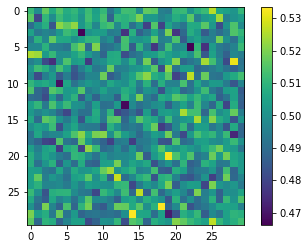

In [129]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [130]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [131]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [132]:
@tf.function
def train_step(sketch, real_ground):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        
        fake_ground = generator(sketch, training=True)
        
        fake_disc = discriminator(sketch, fake_ground, training=True)
        real_disc = discriminator(sketch, real_ground, training=True)
        
        gene_loss, l1_loss = get_gene_loss(fake_ground, real_ground, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

#### 4. 모델 학습

In [133]:
EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS + 1):
    for i, (sketch, ground) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, ground)
        
        if epoch % 10 == 0 and (i+1) % 250 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[10] - STEP[250]                     
Generator_loss:2.5773                     
L1_loss:0.1521                     
Discriminator_loss:0.7261

EPOCH[20] - STEP[250]                     
Generator_loss:2.7726                     
L1_loss:0.1453                     
Discriminator_loss:2.3312

EPOCH[30] - STEP[250]                     
Generator_loss:1.7895                     
L1_loss:0.1718                     
Discriminator_loss:0.6303

EPOCH[40] - STEP[250]                     
Generator_loss:2.6261                     
L1_loss:0.1429                     
Discriminator_loss:2.1851

EPOCH[50] - STEP[250]                     
Generator_loss:1.7568                     
L1_loss:0.1860                     
Discriminator_loss:0.5535

EPOCH[60] - STEP[250]                     
Generator_loss:1.1731                     
L1_loss:0.1801                     
Discriminator_loss:1.5170

EPOCH[70] - STEP[250]                     
Generator_loss:1.5401                     
L1_loss:0.1937      

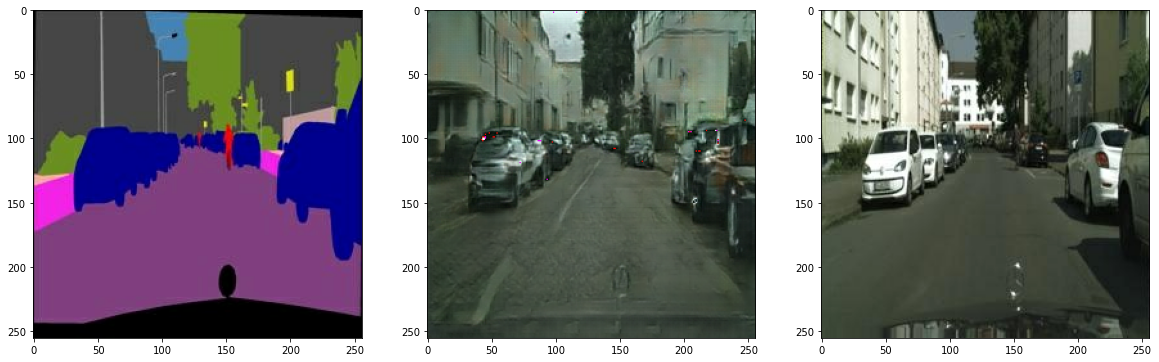

In [134]:
test_ind = 1
data_path = os.getenv('HOME')+'/Aiffel/Exploration/24_sketch_pokemon/cityscapes/val/'

f = data_path + os.listdir(data_path)[test_ind]
sketch, ground = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(ground))

#### 5. 고찰
- 일반적인 GAN으로 학습하는 경우 학습을 하여도 결과가 원하는 데로 잘 나오지 않는 경우가 많아 어려움이 있었는데 cGAN을 활용하여 이러한 문제점을 해결할 수 있어서 흥미로웠다. 
- 이 학습에서는 Augmentation을 padding, crop, 좌우 반전만 사용하였는데 다양한 augmentation을 통해 좀더 다양한 데이터를 이용할 수 있을것이라 생각한다.
- 네트워크를 구현하는 다양한 방법을 학습할 수 있었다.